# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from os import path

print("Loading pickled data...")
DATA_DIR = './data'
MODELS_DIR = './models'

training_file = path.join(DATA_DIR, 'train.p')
testing_file = path.join(DATA_DIR, 'test.p')

# Checking if the data files are available.
# If not, then download the zip and unzip
if not path.exists(training_file) or not path.exists(testing_file):
    print("Data files don't exist. Downloading...")
    from io import BytesIO
    from urllib.request import urlopen
    from zipfile import ZipFile
    
    zipurl = "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(DATA_DIR)

# Load the pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Security check
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
print("Data loading done.")

Loading pickled data...
Data loading done.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = "{}x{}".format(len(X_train[0]), len(X_train[0][0]))

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print()
print("Data summary:")
print()
print("    Training Set:      {} samples".format(n_train))
print("    Test Set:          {} samples".format(n_test))
print("    Image data shape:  {}".format(image_shape))
print("    Number of classes: {}".format(n_classes))


Data summary:

    Training Set:      39209 samples
    Test Set:          12630 samples
    Image data shape:  32x32
    Number of classes: 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization starts here.
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline


Plotting the count of each sign...

    Max observations for class: 2250
    Min observations for class: 210


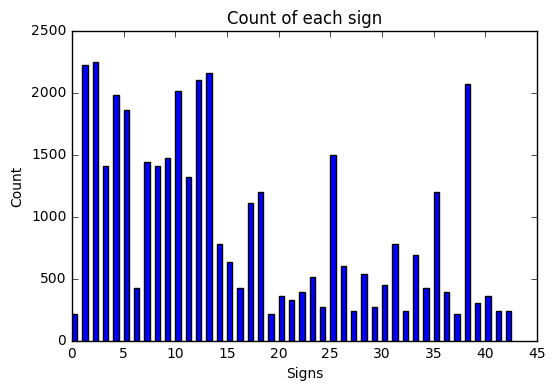

In [4]:
def plot_histogram(labels):
    """
    This function plots a sign class histogram.
    It also prints some useful information about the 
    number of observations per class.    
    :input labels: array with the signs labels for each feature
    """
    print()
    print("Plotting the count of each sign...")

    inputs_per_class = np.bincount(labels)
    max_inputs = np.max(inputs_per_class)
    print()
    print("    Max observations for class: {}".format(max(inputs_per_class)))
    print("    Min observations for class: {}".format(min(inputs_per_class)))
    
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)
    ax.set_ylabel('Count')
    ax.set_xlabel('Signs')
    ax.set_title('Count of each sign')
    ax.bar(range(len(inputs_per_class)), inputs_per_class, 0.5, color='blue')
    
    plt.show()
    
plot_histogram(y_train)

Plotting traffic sign images (randomly per class)...


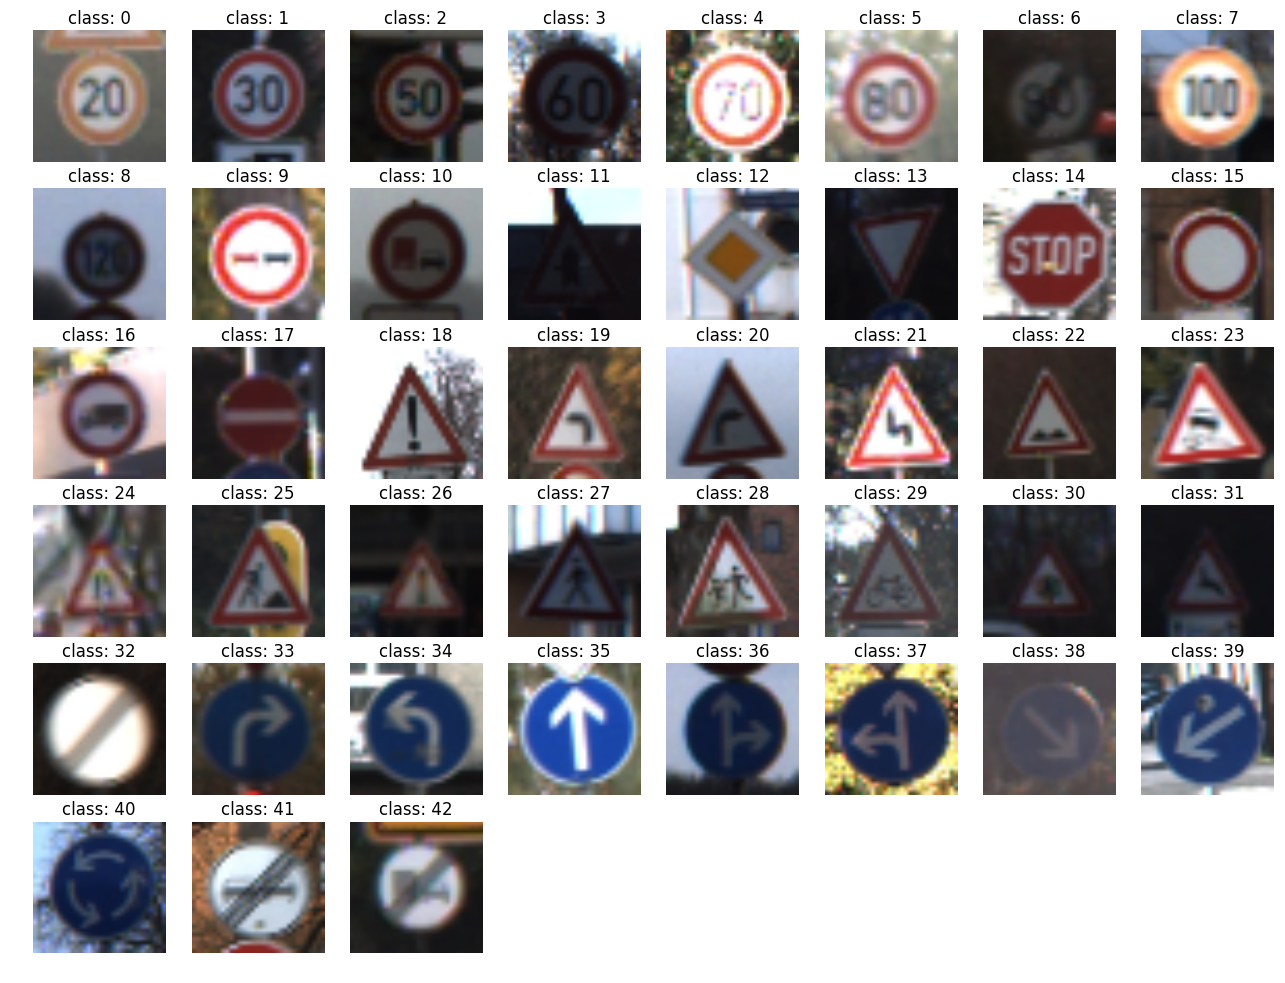

In [5]:
def plot_grid(features, labels):
    """
    This function plots a 8x8 grid of images, and 
    it picks a random image of each class to be showed
    in each cell of the grid.
    :input features: array with the traffic signs
    :input labels: array with the signs labels for each feature
    """
    print('Plotting traffic sign images (randomly per class)...')
    plt.figure(figsize=(16, 16))
    for label in range(len(set(labels))):        
        mask = np.where(labels == label)[0]  # find the indexes of the elements labeled as i
        img = features[np.random.choice(mask)]  # select a random element 
        plt.subplot(8, 8, label+1)
        plt.title('class: {}'.format(label))
        plt.imshow(img)
        plt.axis('off')

    plt.show()

plot_grid(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

To achieve better results, different preprocessing functions has been defined, to be able to study the different results depending on the applyied preprocessing. The functions are:

- Normalizate the values between 0.1 and 0.9, to avoid high data variance
- Apply Gaussian smoothing, using a 5x5 kernel
- (Not done, it's a future improvement) convert RGB to greyscale

Normalizing features...
Normalizing features...
Plotting traffic sign images (randomly per class)...


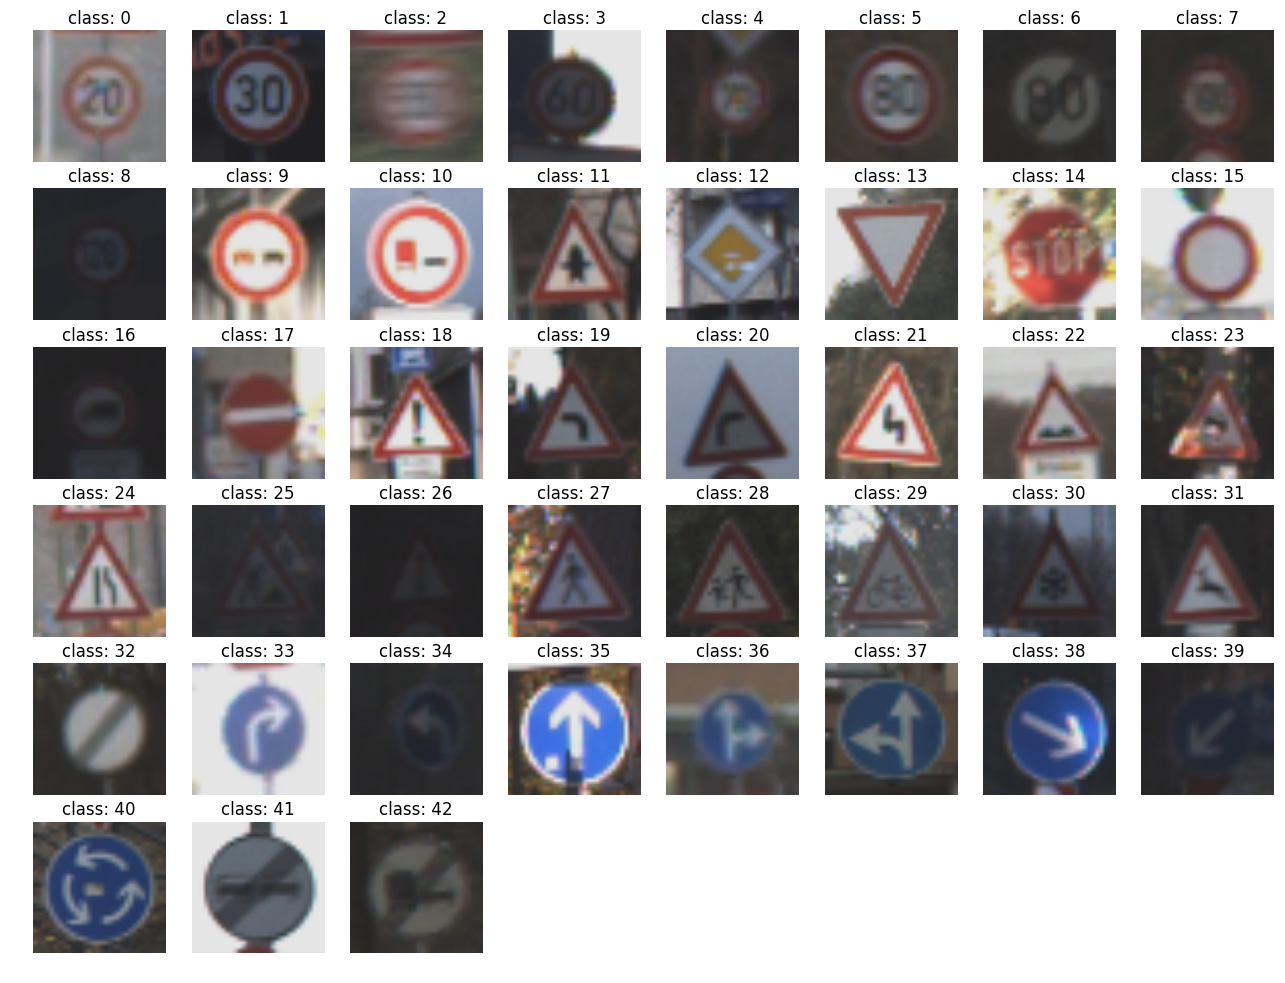

In [6]:
### Generate data additional data (OPTIONAL!)
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    print('Normalizing features...')
    return (image_data * 0.8) / 255. + 0.1

X_train = normalize(X_train)
X_test = normalize(X_test)
plot_grid(X_train, y_train)

Plotting traffic sign images (randomly per class)...


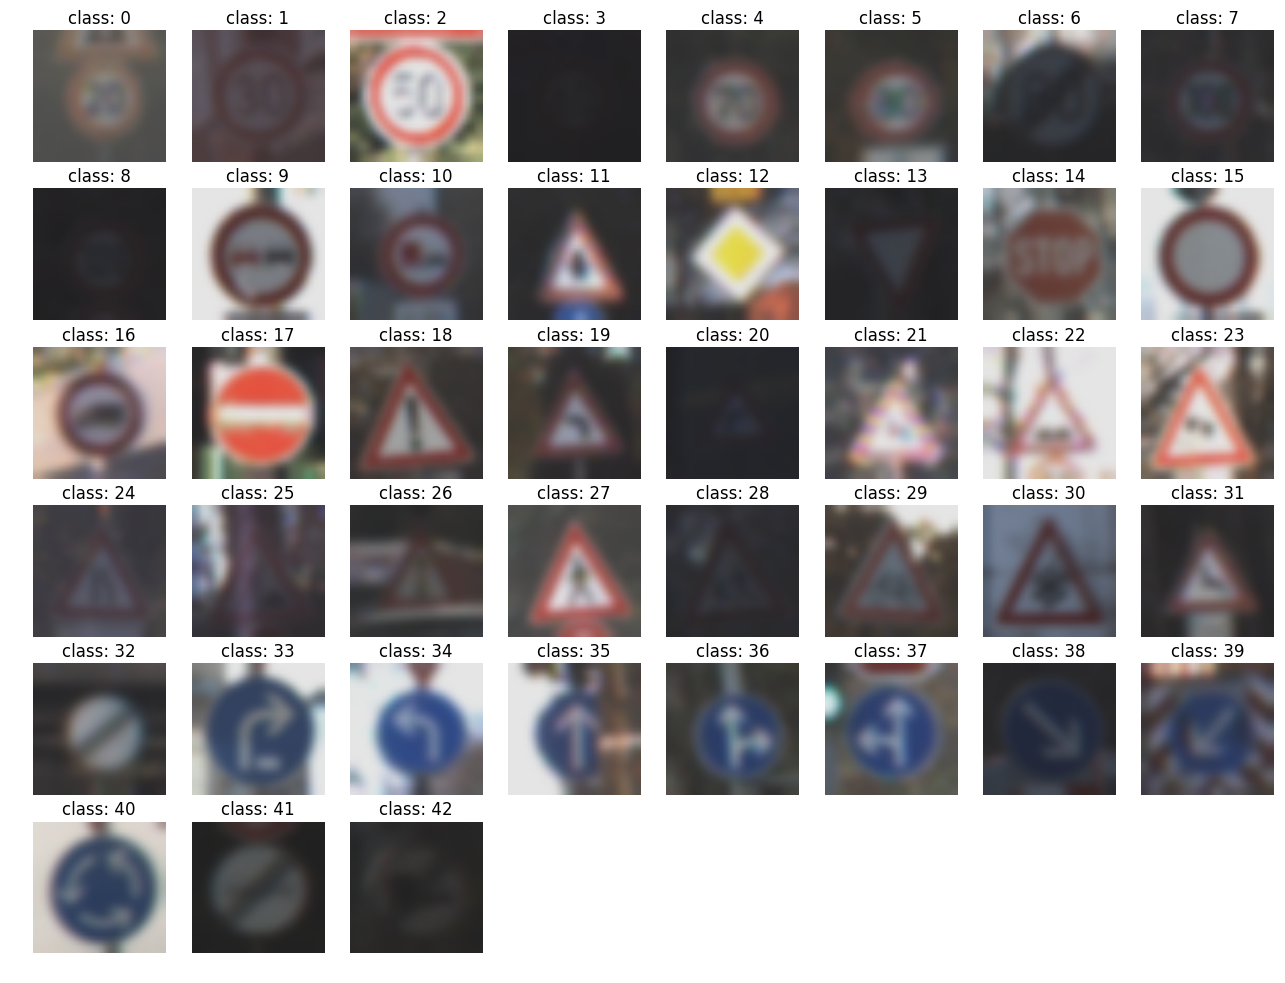

In [7]:
import cv2

def gaussian_blur(image_data):
    """Applies a Gaussian Noise kernel"""
    kernel_size = (5,5)
    return [cv2.GaussianBlur(img, kernel_size, 0) for img in image_data]

X_train = gaussian_blur(X_train)
X_test = gaussian_blur(X_test)
plot_grid(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

On the previous section, exploring the data, I realized that some classes are underrepresented in the training data, at some point with a 1:9 ratio compared with the class with more images. So I prepared a function to generate additional images by applying affine transformations on the original dataset. This function calculates a ratio to generate additional images, applying affine transform to the originals, until I had a roughly similar amount of inputs for each class. The histogram of the new dataset is more balanced than the original. The difference with the original dataset is that there are slightly different images from the originals (translated, sheared and rotated).

The original set of features didn't have a validation dataset. To create it, I splitted the training dataset using a proportion of 80/20, to avoid data overfitting.

Generating additional data...
    New features: 43798

Plotting the count of each sign...

    Max observations for class: 2250
    Min observations for class: 1200


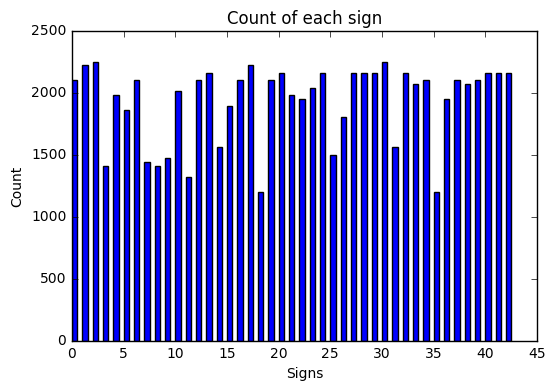

In [8]:
import cv2

# Generate additional data for underrepresented classes
def transform_image(img, ang_range, shear_range, trans_range):
    """
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    """
    
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)

    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_M = cv2.getAffineTransform(pts1, pts2)
        
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    return img

def data_augmentation(features, labels):
    """
    This function it creates additional data, applying affine 
    transformation to images, to balance the number of inputs 
    and reducing the probable bias the network could 
    have towards some classes.
    
    :param features: array with the current features to augment
    :param labels: array with the labels for the current features
    
    :return new_features: array with the new generated features 
    :return new_labels: array with the labels for the new features.
    """
    print('Generating additional data...')
    inputs_per_class = np.bincount(labels)
    max_inputs = np.max(inputs_per_class)

    new_features = []
    new_labels = []
    for label in range(n_classes):
        # calculate a ratio of new images to be generated
        mask = np.where(labels == label)[0]
        class_features = [features[i] for i in mask]
        ratio = int(max_inputs / inputs_per_class[label]) - 1

        for j in range(ratio * len(class_features)):
            feature = class_features[np.random.randint(len(class_features))]
            new_img = transform_image(feature, 20, 10, 5)
            new_features.append(new_img)
            new_labels.append(label)
            
    print("    New features: {}".format(len(new_features)))
    new_features = np.append(features, new_features, axis=0)
    new_labels = np.append(labels, new_labels, axis=0)
    return new_features, new_labels

# The function was designed to be applyed to the working dataset, but after some tests,
# the augmentation was discarted. Here we execute the function to show the new dataset, 
# but it's only as demo. The original code is commented below.
# X_train, y_train = data_augmentation(X_train, y_train)
X_train_augm, y_train_augm = data_augmentation(X_train, y_train)
plot_histogram(y_train_augm)

In [9]:
# There isn't a validation data set, so we create slicing the training set at 80%
print("Slicing the validation set slicing from the training set...")

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# update the global values
n_train = len(X_train)
n_validation = len(X_validation)

print()
print("    Training Set:      {} samples".format(n_train))
print("    Validation Set:    {} samples".format(n_validation))
print("    Test Set:          {} samples".format(n_test))

Slicing the validation set slicing from the training set...

    Training Set:      31367 samples
    Validation Set:    7842 samples
    Test Set:          12630 samples


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The used architecture is based on the LeNet example, with some tweaks and addons.

- Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12. Dropout. Pooling. Input = 28x28x12. Output = 14x14x12.
- Layer 2: Convolutional. Output = 10x10x32. Pooling. Input = 10x10x32. Output = 5x5x32. Flatten. Input = 5x5x32. Output = 800.
- Layer 3: Fully Connected. Input = 800. Output = 240. Dropout.
- Layer 4: Fully Connected. Input = 240. Output = 168.       
- Layer 5: Fully Connected. Input = 168. Output = 86. Layer 5: Fully Connected. Input = 86. Output = 43.

The main modifications are:

- The Layer 1 input size has been changed to accept RGB images (3 channels).
- The Layer 5 output size has been changed from 10 to 43, which is the number of classes to classify.
- Dropout regularization has been added at Layer 1 and Layer 3. 


In [10]:
# Neural network implementation, based on LeNet
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):        
    # Hyperparameters weight initialization
    mu=0
    sigma=0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Apply dropout
    conv1 = tf.nn.dropout(conv1, dropout)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Apply dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

As explained previously, the solution is based on LeNet architecture:

- Adam Optimizer
- A learning rate of 0.001 seemed to learn fast enough without getting stuck in a local minimum.
- Batch size of 256
- Data augmentation wasn't giving better results.

A bunch of automated tests where designed, to find out which preprocessing steps and hyperparameters give better results. Some results of an execution of the tests (this is only a fragment):

```
EPOCHS: 25 dropout: 0.6  mu: 0.000 sigma: 0.100 Validation: 0.913 Test: 0.855
EPOCHS: 25 dropout: 0.6  mu: 0.000 sigma: 0.090 Validation: 0.925 Test: 0.898
EPOCHS: 25 dropout: 0.75 mu: 0.000 sigma: 0.090 Validation: 0.922 Test: 0.874
EPOCHS: 25 dropout: 0.75 mu: 0.000 sigma: 0.100 Validation: 0.944 Test: 0.902
EPOCHS: 25 dropout: 1.0  mu: 0.000 sigma: 0.100 Validation: 0.927 Test: 0.848
EPOCHS: 25 dropout: 0.8  mu: 0.000 sigma: 0.100 Validation: 0.944 Test: 0.906
EPOCHS: 25 dropout: 0.8  mu: 0.000 sigma: 0.100 Validation: 0.911 Test: 0.901
EPOCHS: 25 dropout: 0.8  mu: 0.000 sigma: 0.100 Validation: 0.977 Test: 0.916
EPOCHS: 25 dropout: 0.8  mu: 0.000 sigma: 0.100 Validation: 0.986 Test: 0.905
EPOCHS: 25 dropout: 0.7  mu: 0.000 sigma: 0.100 Validation: 0.987 Test: 0.924
EPOCHS: 25 dropout: 0.7  mu: 0.000 sigma: 0.100 Validation: 0.986 Test: 0.902
EPOCHS: 25 dropout: 0.8  mu: 0.000 sigma: 0.100 Validation: 0.982 Test: 0.916
EPOCHS: 25 dropout: 0.9  mu: 0.000 sigma: 0.100 Validation: 0.985 Test: 0.885
EPOCHS: 25 dropout: 0.6  mu: 0.000 sigma: 0.100 Validation: 0.986 Test: 0.918
EPOCHS: 25 dropout: 0.5  mu: 0.000 sigma: 0.100 Validation: 0.979 Test: 0.910
EPOCHS: 50 dropout: 0.5  mu: 0.000 sigma: 0.100 Validation: 0.988 Test: 0.924
EPOCHS: 50 dropout: 0.6  mu: 0.000 sigma: 0.100 Validation: 0.986 Test: 0.923
EPOCHS: 50 dropout: 0.7  mu: 0.000 sigma: 0.100 Validation: 0.989 Test: 0.919
```

A few observations from the tests:

- Sigma=0.1 is good values for hyperparameters.
- A dropout around 50%-70% gives a better balance between training and test accuracies.
- 50 EPOCHs

In [11]:
# Graph input: Features and Labels 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability value)
one_hot_y = tf.one_hot(y, 43)

# Training Pipeline
rate = 0.001
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

As explained, LeNet was used as baseline architecture, and the initial validation accuracy was around 92%. At this point I wrapped the training model process in a function, being able to launch at different points, using different datasets, and writing the results in an output file:

```
def train_model(X_train, y_train, X_validation, y_validation, X_test, y_test, dropout):
    with tf.Session() as sess:
        # Run the training data through the training pipeline to train the model.
        sess.run(tf.global_variables_initializer())
        ...
        f = open('out.txt', 'a')
        f.write("{}: EPOCHS: {} dropout: {} mu: {:.3f} sigma: {:.3f} Validation: {:.3f} Test: {:.3f}\n".format(
            filename, EPOCHS, DROPOUT, MU, SIGMA, validation_accuracy, test_accuracy))
        f.close()
```

Then I designed a function to create new datasets from zero, applying different preprocessing, and saving the used settings in an output file, to be reviewed later.

```
def preprocess(train, test, norm=False, gauss=False, augm=False):
    X_train, y_train = np.array(train['features']), np.array(train['labels'])
    X_test, y_test = np.array(test['features']), np.array(test['labels'])
    if norm:
        X_train = normalize(X_train)
        X_test = normalize(X_test)
    if gauss:
        X_train = gaussian_blur(X_train)
        X_test = gaussian_blur(X_test)
    if augm:
        X_train, y_train = data_augmentation(X_train, y_train)
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train, y_train, test_size=0.2, random_state=0)
    f = open('out.txt', 'a')
    f.write("--> Normalize:{} - Gauss:{} - Augmentation:{}\n".format(norm, gauss, augm))
    f.close()
    return X_train, y_train, X_validation, y_validation, X_test, y_test
```

Using a few nested loops and the previous functions, was so easy to prepare the execution of different tests to understand how different combinations of preprocessing and paramenters worked: 

```
for norm in [True, False]:
    for gauss in [True, False]:
        for augm in [True, False]:
            X_train, y_train, X_validation, y_validation, X_test, y_test = preprocess(
                train, test, norm=norm, gauss=gauss, augm=augm)
            for EPOCHS in [10,25,50]:
                for dropout in [1.,.9,.8,.7,.6]:
                    train_model(X_train, y_train, X_validation, y_validation, X_test, y_test, dropout)
```

All this process was executed in an EC2 instance, and for this reason I decided to save the different trained models, to be able to use them later in my laptop, restoring the session.

Now all the current code is simplified and uses the final parameters.

In [12]:
import time
from sklearn.utils import shuffle

BATCH_SIZE = 256
DROPOUT = 0.6
EPOCHS = 50
saver = tf.train.Saver()
save_file = MODELS_DIR + '/traffic_model.ckpt'

# # Model Evaluation: Evaluate how well the loss and accuracy of the model for a given dataset.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # passing a keep_prob of 1 to evaluate the network
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
# Model Training

with tf.Session() as sess:
    # Run the training data through the training pipeline to train the model.
    sess.run(tf.global_variables_initializer())

    print("Training...")
    print()
    for i in range(EPOCHS):
        # Before each epoch, shuffle the training set.
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # Run optimization op (backprop)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})

        # After each epoch, measure the loss and accuracy of the validation set.
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    # Save the model after training.
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.373



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The code below shows the 5 selected images, and computes the accuracy of its classification. The selected images consist in 3 black and white signs, and 2 in color.

On a next cell, 5 images from the training dataset are showed. It's easy to see that the incorrect detection corresponds to the B&W signals. Maybe this could be improved converting the training images to greyscale?

Normalizing features...
Showing images...


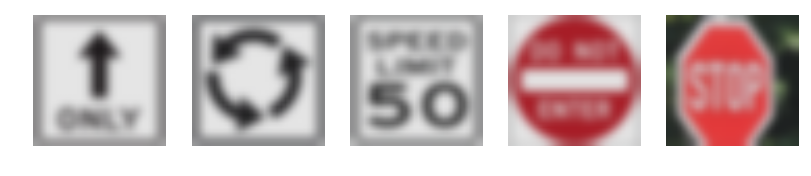

Test Accuracy = 0.400
Predicted classes = [11, 14, 13, 17, 14]


In [92]:
### Load the images and plot them here.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as sciImg

# Visualizations will be shown in the notebook.
%matplotlib inline

def load_images(filename):
    img = mpimg.imread("signs/" + filename)
    return np.array(sciImg.imresize(img, (32, 32), interp='bilinear'))

signs = [
    [35, "aheadOnly.png"],
    #[9, "dontPass.png"],
    [40, "roundAbout.png"],
    [2, "speed50.png"],
    [17, "noEntry.png"],
    [14, "stop.png"],
]

test_images = np.array([load_images(s[1]) for s in signs])
test_labels = np.array([s[0] for s in signs])

# Security check
assert(len(test_images) == len(test_labels))

def plot_images(images):
    """
    This function plots the local images using a 8x8 grid.
    """
    print('Showing images...')
    plt.figure(figsize=(16, 16))
    for i,img in enumerate(images):
        # plot the grid
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

def plot_training_images(labels):
    """
    This function plots the a sample of the training images 
    dataset, according to the parameter "labels", 
    using a 8x8 grid.
    """
    print('Original training dataset images...')
    plt.figure(figsize=(16, 16))
    for i,label in enumerate(labels):
        mask = np.where(y_train == label)[0]
        img = X_train[np.random.choice(mask)]
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

test_images = normalize(test_images)
test_images = gaussian_blur(test_images)

plot_images(test_images)

with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(test_images, test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = []
    for idx in range(len(test_images)):
        pred = sess.run(tf.argmax(logits,1), feed_dict={x: test_images[idx:idx+1], y: test_labels[idx:idx+1], keep_prob: 1.})
        predictions.append(int(pred))
    print("Predicted classes = " + str(predictions))

Original training dataset images...


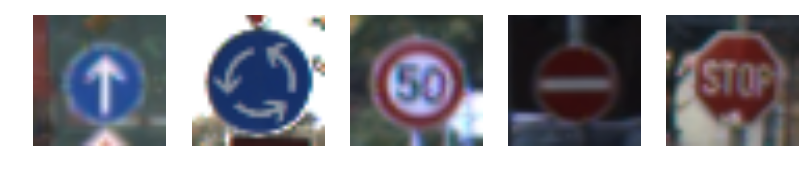

In [75]:
# Here we plot images from the original training dataset
plot_training_images(test_labels)

In [116]:
### Show the softmax probabilities for the downloaded files
import pandas as pd
sign_names = pd.read_csv('signnames.csv')
with tf.Session() as sess:
    saver.restore(sess, save_file)
    for idx,sign in enumerate(signs):
        pred = sess.run(tf.argmax(logits,1), feed_dict={x: test_images[idx:idx+1], y: test_labels[idx:idx+1], keep_prob: 1.})
        print()
        print("File:       {}".format(sign[1]))
        print("Class:      {}".format(sign_names.ix[sign[0]][1]))
        print("Prediction: {}".format(sign_names.ix[int(pred)][1]))


File:       aheadOnly.png
Class:      Ahead only
Prediction: Right-of-way at the next intersection

File:       roundAbout.png
Class:      Roundabout mandatory
Prediction: Stop

File:       speed50.png
Class:      Speed limit (50km/h)
Prediction: Yield

File:       noEntry.png
Class:      No entry
Prediction: No entry

File:       stop.png
Class:      Stop
Prediction: Stop


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

To answer this question, I repeated the same steps done in the previous one, but in this case, I'm using images from the original test dataset. I've defined an array with the indexes of 5 images, corresponding to 5 different classes.

The rest of the process is exactly the same. The result is that using downloaded images from internet, only 2 out of 5 were successfully classified, and now, using the original test dataset, the accuracy is 80%. This is an expected result, as the used model has been trained using similar images.

Normalizing features...
Showing images...


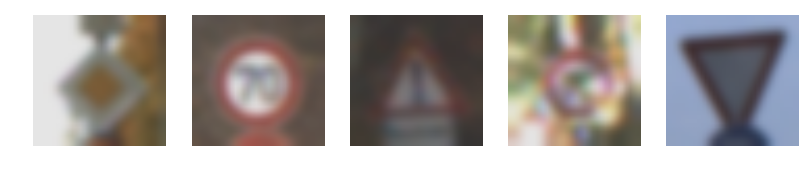

Test Accuracy = 0.800

Class:      Priority road
Prediction: Priority road

Class:      Speed limit (70km/h)
Prediction: Speed limit (70km/h)

Class:      General caution
Prediction: General caution

Class:      Speed limit (70km/h)
Prediction: Speed limit (20km/h)

Class:      Yield
Prediction: Yield


In [85]:
# let's test with images from the original test dataset.
test_signs_idx = [4201, 2251, 1051, 550, 1550]

ti = np.array([X_test[s] for s in test_signs_idx])
tl = np.array([y_test[s] for s in test_signs_idx])

plot_images(ti)

with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(ti, tl)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Show the softmax probabilities for the selected images from test dataset files
with tf.Session() as sess:
    saver.restore(sess, save_file)
    for idx,sign in enumerate(signs):
        pred = sess.run(tf.argmax(logits,1), feed_dict={x: ti[idx:idx+1], y: tl[idx:idx+1], keep_prob: 1.})
        print()
        print("Class:      {}".format(sign_names.ix[tl[idx]][1]))
        print("Prediction: {}".format(sign_names.ix[int(pred)][1]))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [135]:
### Softmax topK probabilities for the downloaded images
with tf.Session() as sess:
    saver.restore(sess, save_file)
    softmax_operation = tf.nn.softmax(logits)
    topk_operation = tf.nn.top_k(softmax_operation, k=5)
    values,indices = sess.run(topk_operation, feed_dict={x: test_images, y: test_labels, keep_prob: 1.})

print()
print("Softmax top 5 probabilities for the downloaded images")
for idx,value in enumerate(values):
    print()
    print("    {}".format(signs[idx][1]))
    for i, v in enumerate(value):
        if int(v*1000)>0:
            print("      {:.1f}% - {}".format(v*100, sign_names.ix[indices[idx][i]][1]))


Softmax top 5 probabilities for the downloaded images

    aheadOnly.png
      98.2% - Right-of-way at the next intersection
      1.1% - Priority road
      0.6% - Double curve

    roundAbout.png
      47.3% - Stop
      33.2% - Yield
      18.3% - No vehicles
      0.5% - Speed limit (30km/h)
      0.3% - Speed limit (60km/h)

    speed50.png
      37.5% - Yield
      28.5% - Go straight or right
      18.0% - Ahead only
      5.1% - Keep right
      3.6% - Children crossing

    noEntry.png
      100.0% - No entry

    stop.png
      100.0% - Stop


**Answer:**

From the downloaded dataset, the model is uncertain of aheadOnly.png, roundAbout.png and speed50.png. The model was able to correctly predict noEntry.png and stop.png. This is perhaps due to the absolutelly different style and black and white the system is unable to recognize features out of.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.